# David Beck CSC578-701 Final Project

#### The goal of this final project is to use a variant of a recurrent neural network called a Long Short Term Memory (LSTM) network to forecast the temperature of the last hour of every 24 hour cycle. By using LSTM, the model designed here can map out long term dependencies and patterns to more accurately predict the target, or temperature, across the time series.

##### Set up and install all required libraries

In [1]:
!conda install -c conda-forge tensorflow-gpu --yes
!conda install -c conda-forge keras-gpu==2.1.5 --yes
import keras; print(keras.__version__) 
!conda install -c conda-forge pandas --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs: 
    - tensorflow-gpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    backports.weakref-1.0rc1   |           py36_0           7 KB  anaconda
    cudnn-6.0.21               |                0       180.0 MB  anaconda
    cudatoolkit-8.0            |                0       319.3 MB  anaconda
    html5lib-0.9999999         |           py36_0         175 KB  anaconda
    tensorflow-gpu-1.2.1       |py36cuda8.0cudnn6.0_0        90.8 MB  anaconda
    bleach-1.5.0               |           py36_0          22 KB  anaconda
    ------------------------------------------------------------
                                           Total:       590.3 MB

The following NEW packages will be INSTALLED:

    backports.weakref: 1.0rc1-py36_0               anaconda
    cudatoolkit:       8.0-0

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.1.5
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs: 
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pandas-0.23.4              |   py36h04863e7_0         9.1 MB  anaconda

The following packages will be UPDATED:

    pandas: 0.23.0-py36h637b7d7_0 --> 0.23.4-py36h04863e7_0 anaconda


pandas-0.23.4        | 9.1 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
# all required libraries, packages, and functions
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# settings
import warnings
warnings.filterwarnings("ignore")

### Load the Hourly Climate data
##### The data provided is a paired down version of weather data set that recorded metrics every 10 minutes over the course of almost two decades. This data set has been trimmed down to the interval of 01.01.2009 to 01.01.2017 on an hourly interval per day.

In [3]:
series = pd.read_csv("/resources/data/climate_hour.csv", header=0)
series.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
70032,31.12.2016 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00
70033,31.12.2016 21:00:00,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50
70034,31.12.2016 22:00:00,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15
70035,31.12.2016 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70
70036,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.90


### Clean data
#### As the date stamps are not a good indicator for predication, this variable is removed and saved for later output to csv file. The target variable, temperature, is moved to the end of the dataframe for ease of access.

In [4]:
# save Date Time stamps and drop them from the data set
dates = series['Date Time']
# replace ' ' with '_' in Date Time
dates = dates.str.replace(' ', '_', regex=True)
print(dates.shape)
series.drop('Date Time', axis=1, inplace=True)
# move target variable to end of data set
target = series['T (degC)']
series.drop('T (degC)', axis=1, inplace=True)
series = pd.concat((series, target), axis=1)
print(series.shape)

(70037,)
(70037, 14)


In [5]:
series.head()

,p (mbar),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),T (degC)
0,996.50,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,-8.05
1,996.62,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,-8.88
2,996.84,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,-8.81
3,996.99,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,-9.05
4,997.46,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,-9.63


### Plot all attribute values of the data set

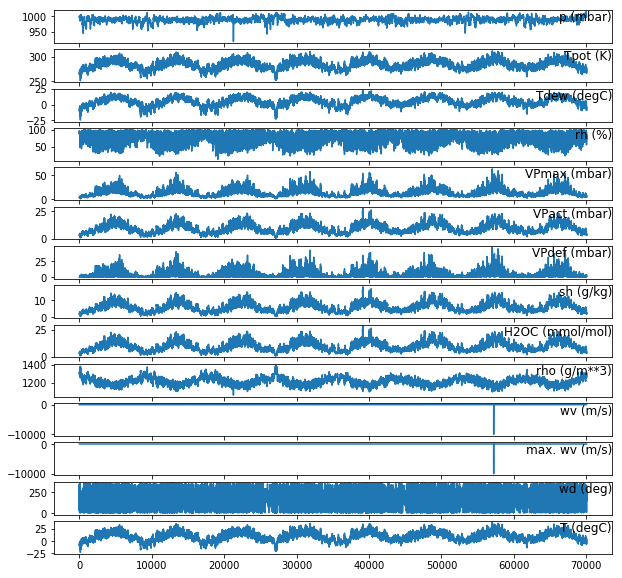

In [6]:
values = series.values
# specify columns to plot
groups = range(0, 14)
i = 1
# plot each column
pyplot.figure(figsize=(10,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(series.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

### Transform data to show 24 hour intervals
#### Here is where we create the time series windows that will be input into the LSTM model. Each single instance in the original dataframe becomes a series of 24 instances that start with itself and the 23 instances that follow it. As the dataframe is shifted, nan-values will inserted when the values do not match up. All instances with nan-values will be dropped at the end.

In [7]:
# create the time series window
window_size = 23
# transform data set to include new time series data
series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
series.dropna(axis=0, inplace=True)

In [8]:
series.shape

(70014, 336)

In [9]:
series.tail()

,p (mbar),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),...,VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),T (degC)
70009,1009.24,270.24,-3.75,89.1,5.19,4.62,0.57,2.86,4.58,1295.33,...,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00,-1.52
70010,1008.93,269.84,-4.99,83.7,5.03,4.21,0.82,2.60,4.17,1297.15,...,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50,-3.09
70011,1008.82,269.50,-4.85,86.9,4.90,4.26,0.64,2.63,4.22,1298.68,...,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15,-2.59
70012,1008.67,268.41,-5.22,91.8,4.51,4.14,0.37,2.56,4.10,1303.88,...,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70,-3.76
70013,1008.18,268.23,-6.80,82.6,4.44,3.67,0.77,2.26,3.64,1304.50,...,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.90,-4.82


### Create and apply MinMax Scaling
#### Normalizing the values will aid in reducing the noisiness of data thereby allowing for more accurate predications. Of course, these values will need to be transformed back once the predication have been made.

In [10]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(series.values)
series = pd.DataFrame(scaled)

### Define targets for training & test sets

In [11]:
# training target
#y_train = series.iloc[1:52543,323:324].values
y_train = series.iloc[1:52543,-1:].values
y_train.shape

(52542, 1)

In [12]:
# first row is 02.01.2009 01:00:00
y_train[:3]

array([[0.30512991],
       [0.30762825],
       [0.30496336]])

In [13]:
# last row is 31.12.2014 23:00:00]
y_train[-3:]

array([[0.41172552],
       [0.41139241],
       [0.41538974]])

In [14]:
# test target
y_test = series.iloc[52543:,-1:].values
y_test.shape

(17471, 1)

In [15]:
# first row is 01.01.2015 00:00:00
y_test[:3]

array([[0.41339107],
       [0.41605596],
       [0.41305796]])

In [16]:
# last row is 01.01.2017 00:00:00
y_test[-3:]

array([[0.3359427],
       [0.3164557],
       [0.2988008]])

### Define training & test sets

In [17]:
# training data set
x_train = series[:52542].values
print(x_train.shape)
# first row is from 01.01.2009 01:00:00 to 02.01.2009 00:00:00 (both inclusive)
x_train[:3]

(52542, 336)


array([[0.80586837, 0.24072233, 0.33556766, ..., 0.99805875, 0.43055556,
        0.30346436],
       [0.80710817, 0.22680583, 0.31483033, ..., 0.99807073, 0.41138889,
        0.30512991],
       [0.80938113, 0.22763419, 0.31713448, ..., 0.99805875, 0.58277778,
        0.30762825]])

In [18]:
# last row is from 30.12.2014 23:00:00 to 31.12.2014 22:00:00 (both inclusive)
x_train[-3:]

array([[0.88810828, 0.38916501, 0.53246753, ..., 0.9981386 , 0.33138889,
        0.41472352],
       [0.885732  , 0.38833665, 0.53037285, ..., 0.99812662, 0.40361111,
        0.41172552],
       [0.88748838, 0.38817097, 0.52576456, ..., 0.99815057, 0.36      ,
        0.41139241]])

In [19]:
# test data set
x_test = series[52542:-1].values
# remove 01.01.2017 01:00:00 instance from x_test
print(x_test.shape)

(17471, 336)


In [20]:
# first row is from 31.12.2014 00:00:00 to 31.12.2014 23:00:00 (both inclusive)
x_test[:3]

array([[0.88955471, 0.38899934, 0.52115626, ..., 0.99805676, 0.39111111,
        0.41538974],
       [0.88666185, 0.38767396, 0.51131127, ..., 0.99806274, 0.76055556,
        0.41339107],
       [0.88604195, 0.39032472, 0.50858819, ..., 0.99805875, 0.33083333,
        0.41605596]])

In [21]:
# last row is from 31.12.2016 00:00:00 to 31.12.2016 23:00:00 (both inclusive)
x_test[-3:]

array([[0.93429073, 0.31461233, 0.41495601, ..., 0.99811864, 0.57638889,
        0.32761492],
       [0.93315425, 0.30897946, 0.41788856, ..., 0.99804278, 0.02263889,
        0.3359427 ],
       [0.9316045 , 0.29092114, 0.41013825, ..., 0.99810067, 0.62138889,
        0.3164557 ]])

In [22]:
# reshape input to be 3D [samples, timesteps, features]
#batch_size = 1
timesteps = 24
data_dim = 14
x_train = x_train.reshape((x_train.shape[0], timesteps, data_dim))
x_test = x_test.reshape((x_test.shape[0], timesteps, data_dim))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(52542, 24, 14) (52542, 1) (17471, 24, 14) (17471, 1)


### Model
#### After numerous trials with a stateful LSTM model, I settled on the below configuration as it gave fairly good predications judging from the Mean Absolute Error values. The highest run returned a score of 0.49.. at 30 epochs.

In [23]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(32, #batch_input_shape=(batch_size, timesteps, data_dim),
               input_shape = (timesteps,data_dim), 
               return_sequences = True))
              #, stateful=True))
model.add(LSTM(32, return_sequences=True))#, stateful=True))
model.add(LSTM(32))#, stateful=True))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mae", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 32)            6016      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 22,689
Trainable params: 22,689
Non-trainable params: 0
_________________________________________________________________


### Fit model and plot history of loss values
#### The loss values reflect the training set & the test set used in place as a validation set.

In [24]:
# fit model & track run time
start = time.time()
history = model.fit(x_train,y_train,batch_size=32,epochs=30,validation_data=(x_test,y_test))
print("> Compilation Time : ", time.time() - start)

Train on 52542 samples, validate on 17471 samples
Epoch 1/30
52542/52542 [==============================] - 279s 5ms/step - loss: 0.0556 - val_loss: 0.0161
Epoch 2/30
52542/52542 [==============================] - 275s 5ms/step - loss: 0.0229 - val_loss: 0.0100
Epoch 3/30
52542/52542 [==============================] - 276s 5ms/step - loss: 0.0209 - val_loss: 0.0118
Epoch 4/30
52542/52542 [==============================] - 275s 5ms/step - loss: 0.0205 - val_loss: 0.0136
Epoch 5/30
52542/52542 [==============================] - 277s 5ms/step - loss: 0.0202 - val_loss: 0.0092
Epoch 6/30
52542/52542 [==============================] - 276s 5ms/step - loss: 0.0202 - val_loss: 0.0109
Epoch 7/30
52542/52542 [==============================] - 277s 5ms/step - loss: 0.0200 - val_loss: 0.0120
Epoch 8/30
52542/52542 [==============================] - 276s 5ms/step - loss: 0.0202 - val_loss: 0.0107
Epoch 9/30
52542/52542 [==============================] - 277s 5ms/step - loss: 0.0199 - val_loss: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



52542/52542 [==============================] - 280s 5ms/step - loss: 0.0197 - val_loss: 0.0091
Epoch 26/30
52542/52542 [==============================] - 280s 5ms/step - loss: 0.0194 - val_loss: 0.0097
Epoch 27/30
52542/52542 [==============================] - 277s 5ms/step - loss: 0.0197 - val_loss: 0.0095
Epoch 28/30
52542/52542 [==============================] - 278s 5ms/step - loss: 0.0196 - val_loss: 0.0113
Epoch 29/30
52542/52542 [==============================] - 278s 5ms/step - loss: 0.0196 - val_loss: 0.0087
Epoch 30/30
52542/52542 [==============================] - 277s 5ms/step - loss: 0.0196 - val_loss: 0.0096
> Compilation Time :  8309.622569084167


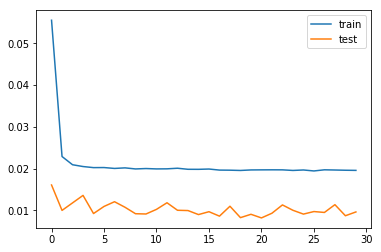

In [25]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Forecast predications and rescale

In [26]:
# make a forecast predication
scaled_preds = model.predict(x_test)#, batch_size=1)
test_X = x_test.reshape((x_test.shape[0], (x_test.shape[1]*x_test.shape[2])))

In [27]:
# invert scaling for forecast
preds = np.concatenate((test_X[:, :-1], scaled_preds), axis=1)
preds = scaler.inverse_transform(preds)
preds = preds[:,-1:]
preds[:3]

array([[2.5796225 ],
       [2.33447157],
       [2.49943003]])

In [28]:
# invert scaling for actual
test_Y = y_test
actuals = np.concatenate((test_X[:, :-1], test_Y), axis=1)
actuals = scaler.inverse_transform(actuals)
actuals = actuals[:,-1:]
actuals[:3]

array([[2.06],
       [2.22],
       [2.04]])

### Mean Absolute Error score
#### This is the measure of accuracy used to evaluate the LSTM model created above.

In [29]:
mean_absolute_error(actuals, preds)

0.5762446176090761

### Prepare predications for export to csv

In [30]:
datestest = dates[52566:]

In [31]:
datestest.tail()

70032    31.12.2016_20:00:00
70033    31.12.2016_21:00:00
70034    31.12.2016_22:00:00
70035    31.12.2016_23:00:00
70036    01.01.2017_00:00:00
Name: Date Time, dtype: object

In [32]:
predstemp = preds.reshape(preds.shape[0],)

In [33]:
predstemp.shape

(17471,)

In [34]:
f = {'date_time': datestest.values,'temperature': predstemp}
final = pd.DataFrame(f)
print(final.head())
print(final.tail())

             date_time  temperature
0  01.01.2015_00:00:00     2.579623
1  01.01.2015_01:00:00     2.334472
2  01.01.2015_02:00:00     2.499430
3  01.01.2015_03:00:00     2.284700
4  01.01.2015_04:00:00     1.989449
                 date_time  temperature
17466  31.12.2016_20:00:00    -1.426295
17467  31.12.2016_21:00:00    -1.639068
17468  31.12.2016_22:00:00    -2.975607
17469  31.12.2016_23:00:00    -2.174297
17470  01.01.2017_00:00:00    -3.288306


In [35]:
final.to_csv("/resources/data/finalproject.csv")